<a href="https://colab.research.google.com/github/kamene22/SAFE-HAVEN-GBV-SUPPORT-ASSISTANT/blob/main/gbv_xlmroberta_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade transformers --quiet
import transformers
print(transformers.__version__)


4.53.1


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer


In [ ]:
from google.colab import files

uploaded = files.upload()  # Upload `gbv_dataset.csv` from your system

Saving gbv_dataset.csv to gbv_dataset.csv


In [ ]:
df = pd.read_csv("gbv_dataset.csv")
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(str)
df.head()

,text,label,county
0,"Niko hatarini, tafadhali nisaidie haraka.",URGENT_HELP,Nyeri
1,"I am in danger, please help me now.",URGENT_HELP,Meru
2,"Amenipiga tena leo, siwezi vumilia.",URGENT_HELP,Nakuru
3,Nahitaji mtu wa kuzungumza naye kuhusu maumivu...,COUNSELING,Meru
4,Nahitaji mtu wa kuzungumza naye kuhusu maumivu...,COUNSELING,Eldoret


In [ ]:
df["clean_text"] = df["text"].str.lower()
df.to_csv("gbv_dataset_cleaned.csv", index=False)

# Save to /project/data
!mkdir -p project/data
!mv gbv_dataset_cleaned.csv project/data/

**Encode Labels**

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["label"])



**Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"].tolist(),
    df["label_id"].tolist(),
    test_size=0.2,
    stratify=df["label_id"],
    random_state=42
)

**Text Tokenization**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

**Creating a pytorch Dataset**

In [ ]:
import torch

class GBVDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = GBVDataset(train_encodings, train_labels)
test_dataset = GBVDataset(test_encodings, test_labels)


**Model Training**

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer
from transformers.training_args import TrainingArguments  # ✅ Force correct import

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=len(label_encoder.classes_)
)

# ⬇️ MINIMAL TrainingArguments - removes advanced features
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs"
)

# Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss


TrainOutput(global_step=300, training_loss=0.13514612833658854, metrics={'train_runtime': 1718.6567, 'train_samples_per_second': 1.396, 'train_steps_per_second': 0.175, 'total_flos': 20967038726400.0, 'train_loss': 0.13514612833658854, 'epoch': 3.0})

**Model Evaluation**

                 precision    recall  f1-score   support

     COUNSELING       1.00      1.00      1.00        50
      LEGAL_AID       1.00      1.00      1.00        50
SEEKING_SHELTER       1.00      1.00      1.00        50
    URGENT_HELP       1.00      1.00      1.00        50

       accuracy                           1.00       200
      macro avg       1.00      1.00      1.00       200
   weighted avg       1.00      1.00      1.00       200



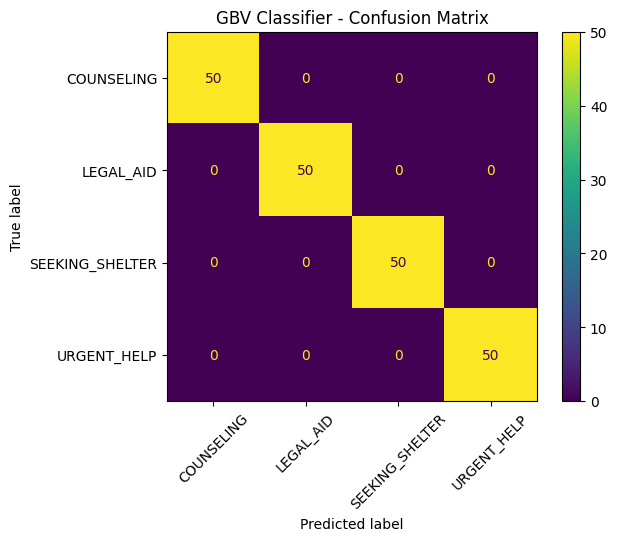

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predictions from test set
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = test_labels  # from your earlier split

# Classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45)
plt.title("GBV Classifier - Confusion Matrix")
plt.savefig("confusion_matrix_v1.png")
plt.show()


In [ ]:
model.save_pretrained("gbv_xlmroberta_model")
tokenizer.save_pretrained("gbv_xlmroberta_model")


('gbv_xlmroberta_model/tokenizer_config.json',
 'gbv_xlmroberta_model/special_tokens_map.json',
 'gbv_xlmroberta_model/sentencepiece.bpe.model',
 'gbv_xlmroberta_model/added_tokens.json',
 'gbv_xlmroberta_model/tokenizer.json')